<h1> Исследовательский анализ данных </h1>
</br>

<h2>Загрузка данных:</h2>

In [58]:
import pandas as pd
import matplotlib as plt 
import seaborn as sns 
df = pd.read_csv("creditcard.csv")
df.info()
metrics = []


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Нет отсутствующих данных. 

<h3>Распределение целевой переменной</h3>

In [59]:
class_names = {0: "Немошеннические транзакции", 1: "Мошеннические транзакции"} 
counts = df["Class"].value_counts().rename(index={0: "Немошеннические транзакции", 1: "Мошеннические транзакции"})
print(counts)

Class
Немошеннические транзакции    284315
Мошеннические транзакции         492
Name: count, dtype: int64


<br>Мы видим, что классы распределены неравномерно, и это нужно будет учитывать в дальнейшем анализе. </br> 

<h3>Остальные переменные:</h3>
<p>Нам дано, что остальные переменные были получены из PCA. В таком случае, корреляционная матрица этих переменных должна быть диагональной, так как вектора переменных ортогональны друг другу </p>

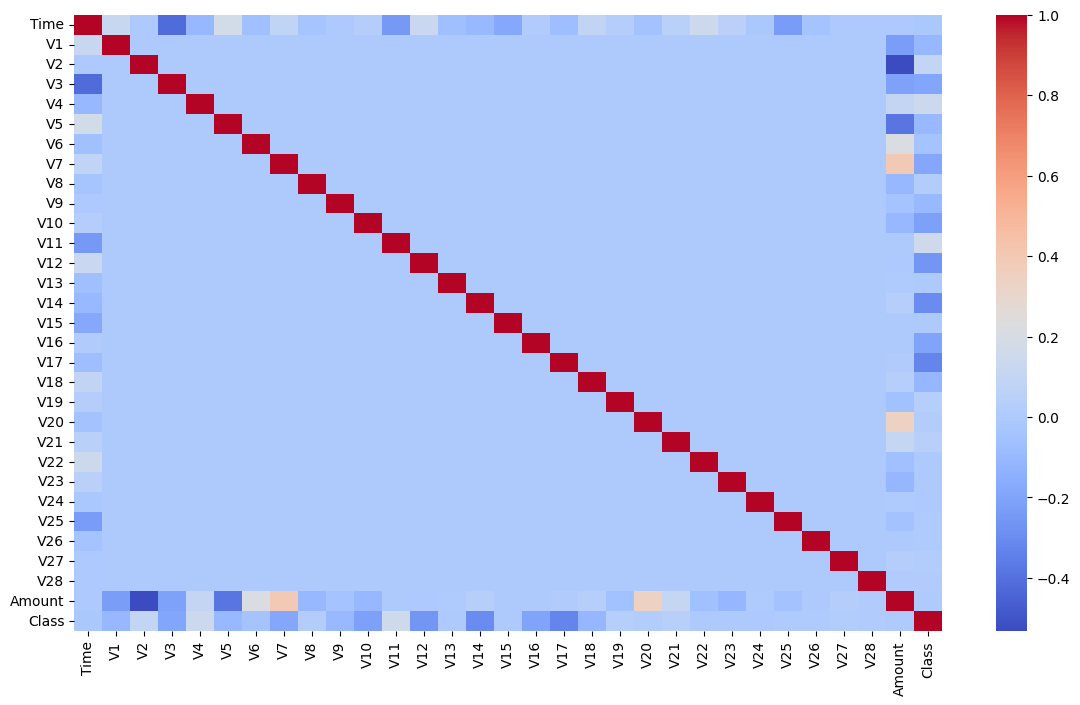

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = df.corr()
plt.figure(figsize=(14, 8))  
sns.heatmap(corr,cmap="coolwarm")
plt.show()

Действительно, заметные колебания корреляции проявляются лишь во времени, в количестве и в результате.
V4, V8, V11 положительно коррелируют с мошенническими транзакциями(т.е. чем больше их значения, тем вероятнее, что транзакция -- мошенническая). 
V12, V14, V17 отрицательно коррелируют (коофицент Пирсена в [-0.4,-0.2]). Так как данные несбалансированны, выводы делать нельзя. 

<h4> </h4>

<hr>


<h1>Моделирование</h1>
<p>Модель 1: Случайный лес с весами, будем использовать "наивный вес" для 1-го класса, то есть пропорцию мошеннических транзакций </p>

{'0': {'precision': 0.9994843911127778, 'recall': 0.9999648279500557, 'f1-score': 0.9997245518106322, 'support': 85295.0}, '1': {'precision': 0.9719626168224299, 'recall': 0.7027027027027027, 'f1-score': 0.8156862745098039, 'support': 148.0}, 'accuracy': 0.9994499256814484, 'macro avg': {'precision': 0.9857235039676038, 'recall': 0.8513337653263793, 'f1-score': 0.907705413160218, 'support': 85443.0}, 'weighted avg': {'precision': 0.9994367193012195, 'recall': 0.9994499256814484, 'f1-score': 0.9994057701077366, 'support': 85443.0}}


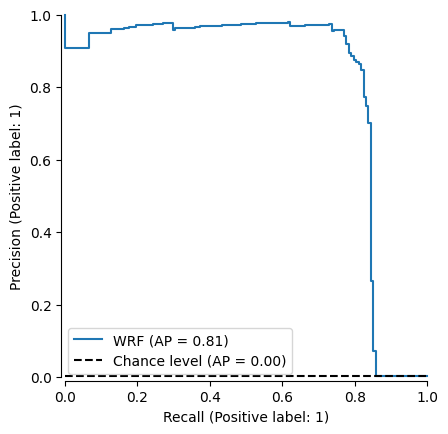

In [63]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import PrecisionRecallDisplay
# Split data
X = df.drop(columns=["Class"])
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)             
y_proba = rf.predict_proba(X_test)[:, 1] 

display1 = PrecisionRecallDisplay.from_predictions(y_test, y_proba,name="WRF", plot_chance_level=True, despine=True)
report_wrf = classification_report(y_test, y_pred, output_dict=True)
print(report_wrf)
metrics.append({
    "Model": "WRF",
    "Precision": report_wrf["1"]["precision"],
    "Recall": report_wrf["1"]["recall"],
    "F1": report_wrf["1"]["f1-score"]
})


Примечание: ROC-AUC может быть обманчивым, когда применяется к несбалансированным данным, ибо даже если модель делает много неверных срабатываний, показатель FPR остаётся низким из-за большого знаменателя (TN + FP). В итоге кривая ROC и значение AUC могут выглядеть "хорошо", хотя модель почти не умеет находить редкий положительный класс. В таких случаях информативнее анализировать Precision–Recall (PR) кривую.

<h2>CatBoost с дефолтными параметрами</h2>

{'0': {'precision': 0.9995780837972458, 'recall': 0.9999296559001114, 'f1-score': 0.9997538389403352, 'support': 85295.0}, '1': {'precision': 0.9491525423728814, 'recall': 0.7567567567567568, 'f1-score': 0.8421052631578947, 'support': 148.0}, 'accuracy': 0.9995084442259752, 'macro avg': {'precision': 0.9743653130850636, 'recall': 0.8783432063284341, 'f1-score': 0.9209295510491149, 'support': 85443.0}, 'weighted avg': {'precision': 0.9994907392502284, 'recall': 0.9995084442259752, 'f1-score': 0.9994807681303707, 'support': 85443.0}}
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     85295
           1     0.9492    0.7568    0.8421       148

    accuracy                         0.9995     85443
   macro avg     0.9744    0.8783    0.9209     85443
weighted avg     0.9995    0.9995    0.9995     85443



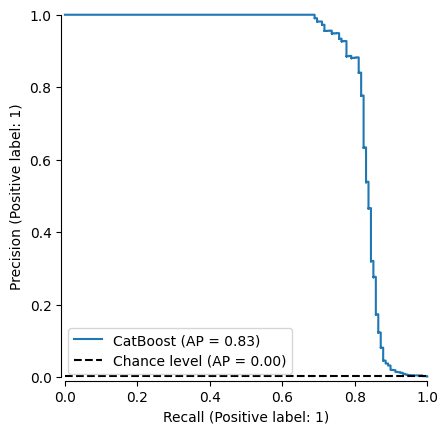

In [64]:
from catboost import CatBoostClassifier
cb_tree = CatBoostClassifier(verbose=0, random_state=42)
cb_tree.fit(X_train, y_train)
y_pred_cb = cb_tree.predict(X_test)
y_proba_cb = cb_tree.predict_proba(X_test)[:, 1]
display1 = PrecisionRecallDisplay.from_predictions(y_test, y_proba_cb,name="СatBoost", plot_chance_level=True, despine=True)
report_cb = classification_report(y_test, y_pred_cb, output_dict=True)
print(report_cb)
metrics.append({
    "Model": "CatBoost",
    "Precision": report_cb["1"]["precision"],
    "Recall": report_cb["1"]["recall"],
    "F1": report_cb["1"]["f1-score"]
})
print(classification_report(y_test, y_pred_cb, digits=4))


{'0': {'precision': 0.9996015095754905, 'recall': 0.9999179318834632, 'f1-score': 0.9997596956926919, 'support': 85295.0}, '1': {'precision': 0.9421487603305785, 'recall': 0.7702702702702703, 'f1-score': 0.8475836431226765, 'support': 148.0}, 'accuracy': 0.9995201479348805, 'macro avg': {'precision': 0.9708751349530345, 'recall': 0.8850941010768667, 'f1-score': 0.9236716694076842, 'support': 85443.0}, 'weighted avg': {'precision': 0.9995019928580503, 'recall': 0.9995201479348805, 'f1-score': 0.9994961041078885, 'support': 85443.0}}


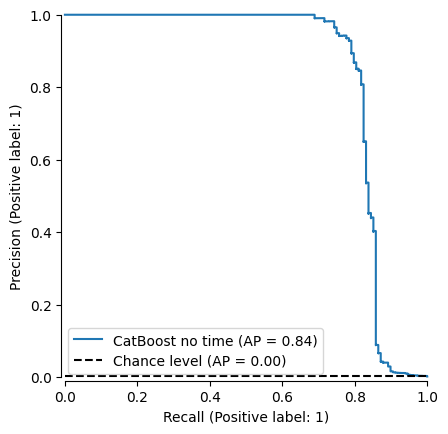

In [65]:
#без времени
X_train_ntime = X_train.drop(columns="Time")
cb_tree_nt = CatBoostClassifier(verbose=0, random_state=42)
cb_tree_nt.fit(X_train_ntime, y_train)
X_test_nt = X_test.drop(columns="Time")
y_pred_cb_nt = cb_tree_nt.predict(X_test_nt)
y_proba_cb_nt = cb_tree_nt.predict_proba(X_test_nt)[:, 1]
display1 = PrecisionRecallDisplay.from_predictions(y_test, y_proba_cb_nt,name="СatBoost no time", plot_chance_level=True, despine=True)
report_cb_nt = classification_report(y_test, y_pred_cb_nt, output_dict=True)
print(report_cb_nt)
metrics.append({
    "Model": "CatBoost w/o Time",
    "Precision": report_cb_nt["1"]["precision"],
    "Recall": report_cb_nt["1"]["recall"],
    "F1": report_cb_nt["1"]["f1-score"]
})


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
_ = ConfusionMatrixDisplay.from_estimator(cb_tree_nt, X_test_nt, y_test)


<p>Попробуем провести анализ на сбалансированных данных (SMOTE oversampling). </p>

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42) 
X_res, Y_res = smote.fit_resample(X_train, y_train)

In [ ]:
class_counts = Y_res.value_counts()
class_counts

In [ ]:
#деревья на сбалансированных данных 
X_train_ntime = X_res.drop(columns="Time")
cb_tree_nt = CatBoostClassifier(verbose=0, random_state=42,task_type="GPU")
cb_tree_nt.fit(X_train_ntime, Y_res)
X_test_nt = X_test.drop(columns="Time")
y_pred_cb_nt = cb_tree_nt.predict(X_test_nt)
y_proba_cb_nt = cb_tree_nt.predict_proba(X_test_nt)[:, 1]


Вероятно, модель переобучилась на синтетических данных и показывает слабые результаты на тестовой выборке.
</br>

<h2>Анализ</h2>


In [66]:
metrics_df = pd.DataFrame(metrics).round(4)
print(metrics_df)

               Model  Precision  Recall      F1
0                WRF     0.9720  0.7027  0.8157
1           CatBoost     0.9492  0.7568  0.8421
2  CatBoost w/o Time     0.9421  0.7703  0.8476


<b> Вывод: </b> CatBoost без использования переменной "Time" показал лучшие значения F1 и Recall, поэтому именно эту модель целесообразно выбрать.